In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import gpytorch
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
import numpy as np

import matplotlib.pyplot as plt
from figurefirst import mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import odor_stat_calculations as osc



### Gaussian Processes

In [8]:
# Define the GP Model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def load_and_preprocess_file(file_path, features, target):
    df = pd.read_hdf(file_path)
    scaler = MinMaxScaler()
    df[features] = scaler.fit_transform(df[features])
    feature_tensors = torch.Tensor(df[features].values)
    target_tensors = torch.Tensor(df[target].values)
    return feature_tensors, target_tensors

def create_sequences(feature_tensors, target_tensors, seq_length):
    sequences = []
    targets = []
    for i in range(len(feature_tensors) - seq_length):
        sequences.append(feature_tensors[i:i+seq_length])
        targets.append(target_tensors[i+seq_length])
    return torch.stack(sequences), torch.stack(targets)


def predict_on_new_data(model, likelihood, new_data_path, features, target):
    # Load and preprocess the new data
    feature_tensors, _ = load_and_preprocess_file(new_data_path, features, target)

    # Move the tensors to the same device as the model
    device = next(model.parameters()).device
    feature_tensors = feature_tensors.to(device)

    # Make predictions
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(feature_tensors))
    return observed_pred.mean.cpu().numpy()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [9]:
features = ['distance_along_streakline', 'nearest_from_streakline']
target = ['odor']

folder_path = "/home/beast/An/data/Sept13Plumes/plume1/train/"

all_filenames = [filename for filename in os.listdir(folder_path) if filename.startswith("diag") and filename.endswith(".h5")]
sorted_filenames = sorted(all_filenames, key=lambda x: int(x[4:-3]))

# Initialize the GP model and likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()

training_iterations = 300

# Iterate over files
for file in sorted_filenames:
    file_path = os.path.join(folder_path, file)
    
    # Load and preprocess the data from the current file
    train_x, train_y = load_and_preprocess_file(file_path, features, target)
    train_y = train_y.squeeze()
    train_x = train_x.to(device)
    train_y = train_y.to(device)

    
    # Define a new GP model using the data from the current file
    model = ExactGPModel(train_x, train_y, likelihood).to(device)
    model.train()
    likelihood.train()
    
    # Initialize the optimizer here, after the model is defined
    optimizer = torch.optim.Adam([{'params': model.parameters()},], lr=0.1)
    
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

        if (i + 1) % 200 == 0:  
            print(f'Epoch [{i + 1}/{training_iterations}], File: {file}, Loss: {loss.item()}')


Epoch [200/300], File: diag1.h5, Loss: 0.5456075668334961
Epoch [200/300], File: diag2.h5, Loss: 0.4340546727180481
Epoch [200/300], File: diag3.h5, Loss: 0.5416433215141296
Epoch [200/300], File: diag4.h5, Loss: 1.196664810180664
Epoch [200/300], File: diag5.h5, Loss: 0.8629838228225708
Epoch [200/300], File: diag6.h5, Loss: 0.3761158883571625
Epoch [200/300], File: diag7.h5, Loss: 0.46735212206840515
Epoch [200/300], File: diag8.h5, Loss: 0.2541150450706482
Epoch [200/300], File: diag9.h5, Loss: 0.0452258326113224
Epoch [200/300], File: diag10.h5, Loss: 0.7330514192581177
Epoch [200/300], File: diag11.h5, Loss: 0.7252786159515381
Epoch [200/300], File: diag12.h5, Loss: -3.476855993270874
Epoch [200/300], File: diag13.h5, Loss: 1.587766408920288
Epoch [200/300], File: diag14.h5, Loss: 1.289503574371338
Epoch [200/300], File: diag15.h5, Loss: 0.0827803835272789
Epoch [200/300], File: diag16.h5, Loss: 0.6985557079315186
Epoch [200/300], File: diag17.h5, Loss: 1.1407263278961182
Epoch [2

/home/beast/.local/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.3457626104354858 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.436826229095459 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: Num

Epoch [200/300], File: diag41.h5, Loss: 1.386165738105774
Epoch [200/300], File: diag42.h5, Loss: 0.8698742389678955
Epoch [200/300], File: diag43.h5, Loss: 0.7008622288703918
Epoch [200/300], File: diag44.h5, Loss: 0.5260122418403625
Epoch [200/300], File: diag45.h5, Loss: 0.5041106939315796
Epoch [200/300], File: diag46.h5, Loss: 0.4932522177696228
Epoch [200/300], File: diag47.h5, Loss: 0.012145298533141613
Epoch [200/300], File: diag48.h5, Loss: 1.2061536312103271
Epoch [200/300], File: diag49.h5, Loss: 1.2745606899261475
Epoch [200/300], File: diag50.h5, Loss: 0.825391411781311
Epoch [200/300], File: diag51.h5, Loss: 0.3121005594730377
Epoch [200/300], File: diag52.h5, Loss: 0.3284875452518463
Epoch [200/300], File: diag53.h5, Loss: 0.3925718665122986
Epoch [200/300], File: diag54.h5, Loss: 0.2658507227897644
Epoch [200/300], File: diag55.h5, Loss: 0.32287463545799255
Epoch [200/300], File: diag56.h5, Loss: 0.8560733199119568
Epoch [200/300], File: diag57.h5, Loss: 0.6968574523925

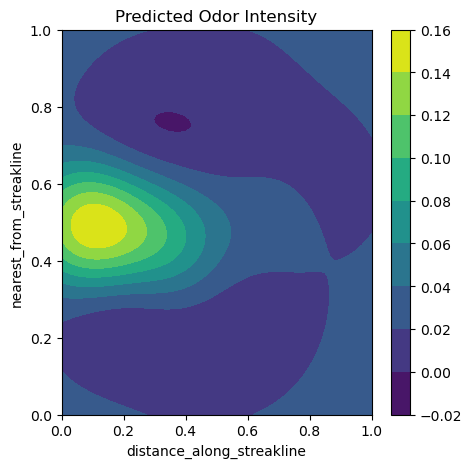

In [13]:
def test_gp_model(model, likelihood, test_x):
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))
    return observed_pred.mean.cpu().numpy(), observed_pred.variance.cpu().numpy()

# Generate a grid for visualization
def generate_grid():
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)
    xv, yv = np.meshgrid(x, y)
    grid_points = np.c_[xv.ravel(), yv.ravel()]
    return torch.Tensor(grid_points).to(device), xv, yv

# Visualization function
def visualize_predictions(predicted_means, xv, yv):
    plt.figure(figsize=(5,5))
    plt.contourf(xv, yv, predicted_means.reshape(100, 100))
    plt.colorbar()
    plt.title('Predicted Odor Intensity')
    plt.xlabel('distance_along_streakline')
    plt.ylabel('nearest_from_streakline')
    plt.show()

# Generate grid
grid_tensors, xv, yv = generate_grid()

# Make predictions on the grid
predicted_means, _ = test_gp_model(model, likelihood, grid_tensors)

# Visualize the predictions
visualize_predictions(predicted_means, xv, yv)




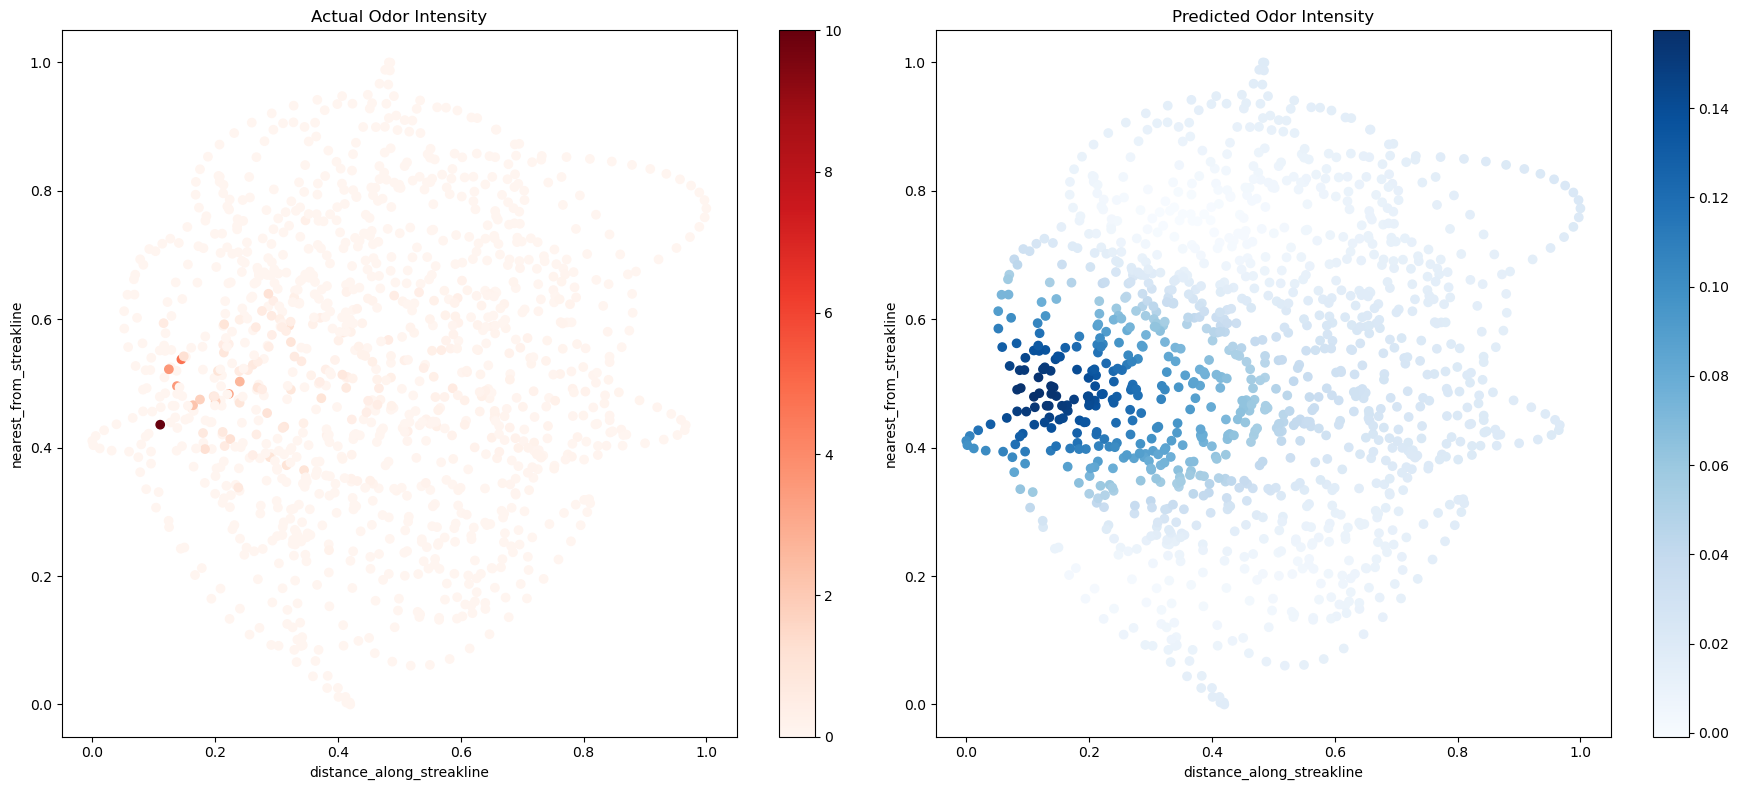

In [19]:
def compare_spatial_predictions_separately(test_x, predicted_means, actual_values):
    # Convert test_x back to CPU for visualization
    test_x_cpu = test_x.cpu().numpy()

    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot the actual values
    scatter_actual = ax[0].scatter(test_x_cpu[:, 0], test_x_cpu[:, 1], c=actual_values, cmap='Reds')
    ax[0].set_title('Actual Odor Intensity')
    ax[0].set_xlabel('distance_along_streakline')
    ax[0].set_ylabel('nearest_from_streakline')
    fig.colorbar(scatter_actual, ax=ax[0])
    
    # Plot the predicted values
    scatter_predicted = ax[1].scatter(test_x_cpu[:, 0], test_x_cpu[:, 1], c=predicted_means, cmap='Blues')
    ax[1].set_title('Predicted Odor Intensity')
    ax[1].set_xlabel('distance_along_streakline')
    ax[1].set_ylabel('nearest_from_streakline')
    fig.colorbar(scatter_predicted, ax=ax[1])
    
    plt.tight_layout()
    plt.show()

# Compare the spatial predictions with the actual values in separate plots
compare_spatial_predictions_separately(test_x, predicted_means, test_y)


In [81]:
new_data_path = "/home/beast/An/data/train_new_axis/diag10.h5"
predictions = predict_on_new_data(model, likelihood, new_data_path, features, target)

# Append predictions to the original data
test = pd.read_hdf(new_data_path)
test['predicted_odor'] = np.pad(predictions, (0, len(test)-len(predictions)), mode='constant')


Text(0.5, 1.0, '300ep/timeseries')

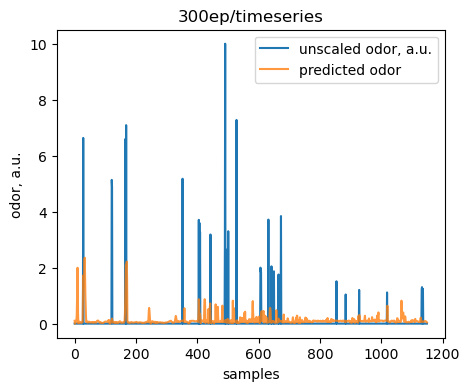

In [82]:
f,ax=plt.subplots(1,1,figsize=(5,4))
ax.plot(test.odor, label='unscaled odor, a.u.')
ax.plot(test.predicted_odor, alpha=0.8,label='predicted odor')
ax.set_ylabel('odor, a.u.')
ax.set_xlabel('samples')
ax.legend()
ax.set_title('300ep/timeseries')
# mpl_functions.set_fontsize(f, 15)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

In [60]:
# test['scaled_odor']=scale_data(test.odor)
query='odor>1'
df = test.query(query)
df.reset_index(drop=True, inplace=True)

query1='predicted_odor>1'
df1 = test.query(query1)
df1.reset_index(drop=True, inplace=True)


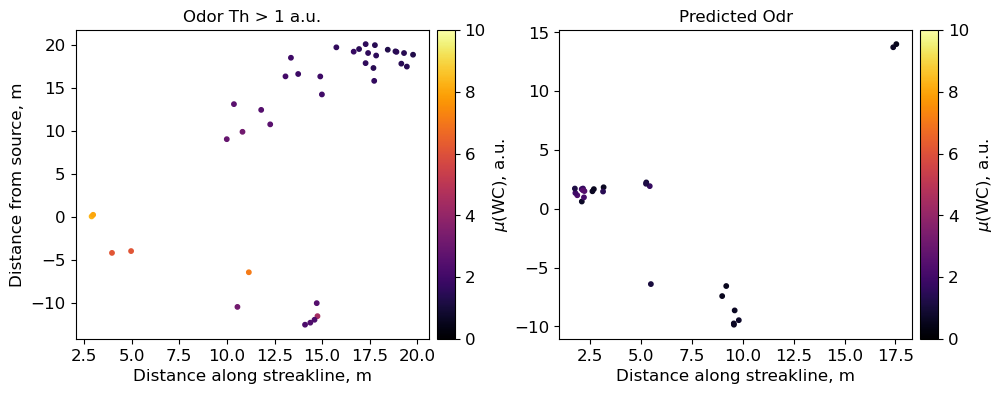

In [62]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
v = ax1.scatter(df.distance_along_streakline, df.nearest_from_streakline, c=df.odor, 
             s=10, cmap='inferno', vmin=0,vmax=10)

ax1.set_title('Odor Th > 1 a.u.')
ax1.set_ylabel('Distance from source, m')
ax1.set_xlabel('Distance along streakline, m')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(v, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

w = ax2.scatter(df1.distance_along_streakline, df1.nearest_from_streakline, c=df1.predicted_odor, 
             s=10, cmap='inferno', vmin=0,vmax=10)

ax2.set_title('Predicted Odr')
# ax2.set_ylabel('Distance from source, m')
ax2.set_xlabel('Distance along streakline, m')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(w, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

f.tight_layout(pad=1)
mpl_functions.set_fontsize(f, 12)

In [57]:
test['scaled_odor']=osc.scale_data(test.odor)

osc.get_time_col(test,0.3)
# osc.calculate_distance_from_source(test)

In [58]:
def cal_stat(df,index, index_predicted,fdf, fdf_predicted):
    osc.avg_distance(df,index,fdf)
    osc.whiff_blank_duration(df,index,fdf)
    osc.mean_conc(df,index,fdf)
    
    osc.avg_distance(df,index_predicted,fdf_predicted)
    osc.whiff_blank_duration(df,index_predicted,fdf_predicted)
    
    osc.predicted_mean_conc(df,index_predicted,fdf_predicted)

np.seterr(divide='ignore')
index = osc.get_index(test.odor,0.5)
index_predicted = osc.get_index(test.predicted_odor,0.5)
fdf = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(test,index,index_predicted,fdf, fdf_predicted)

fdf.keys()

Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'length_of_encounter', 'odor_intermittency', 'log_whiff', 'log_blank',
       'mean_concentration'],
      dtype='object')

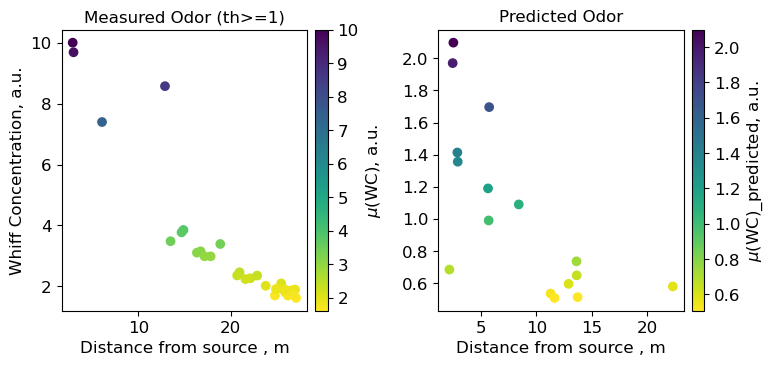

In [59]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf.avg_dist_from_source,fdf.mean_concentration, c=fdf.mean_concentration, cmap='viridis_r' )
ax1.set_ylabel('Whiff Concentration, a.u.')
ax1.set_xlabel('Distance from source , m')
ax1.set_title('Measured Odor (th>=1)')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')


u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.mean_concentration_p, 
              c=fdf_predicted.mean_concentration_p, cmap='viridis_r' )
# ax2.set_ylabel('Whiff Concentration, a.u.')
ax2.set_xlabel('Distance from source , m')
ax2.set_title('Predicted Odor')
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

f.tight_layout(pad=2)

mpl_functions.set_fontsize(f, 12)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

In [15]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from matplotlib import pyplot as plt
import os
from concurrent.futures import ProcessPoolExecutor

In [1]:

# Define the kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# Define the function to train the GP for a given file
def train_gp_for_file(file):
    file_path = os.path.join(folder_path, file)
    
    # Load the data
    df = pd.read_hdf(file_path)
    X = df[['distance_along_streakline', 'nearest_from_streakline']].values
    y = df['odor'].values
    
    # Create and train the GP regressor
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1)
    gp.fit(X, y)
    
    # Predictions
    y_pred, sigma = gp.predict(X, return_std=True)
    
    # You can return any metrics or results here if needed
    # For now, just return the file name to indicate completion
    return file

folder_path = "/home/beast/An/data/Sept13Plumes/plume1/train/"
all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Using a ProcessPoolExecutor to parallelize the training
with ProcessPoolExecutor() as executor:
    for file, result in zip(all_files, executor.map(train_gp_for_file, all_files)):
        print(f"Completed training for file: {result}")

In [10]:
# Load the new dataset
df_new = pd.read_hdf("/home/beast/An/data/Sept13Plumes/plume1/train/diag21.h5")

# Extract spatial features
X_new = df_new[['distance_along_streakline', 'nearest_from_streakline']].values
y_true_new = df_new['odor'].values

# Make predictions using the trained GP model
y_pred_new, sigma_new = gp.predict(X_new, return_std=True)

# Visualization of predictions on the new dataset
plt.figure(figsize=(10, 5))
plt.plot(y_true_new, 'r.', markersize=10, label='True Odor Value (New Data)')
plt.plot(y_pred_new, 'b-', label='Predicted Odor Value (New Data)')
plt.fill_between(np.arange(len(y_pred_new)), y_pred_new - 1.96*sigma_new, y_pred_new + 1.96*sigma_new, alpha=0.2, color='k')
plt.title("True vs Predicted Odor Values for New Data")
plt.xlabel("Data Point Index")
plt.ylabel("Odor Value")
plt.legend()
plt.show()

# If needed, you can also compute metrics (e.g., RMSE) to quantify the performance
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_true_new, y_pred_new))
print(f"RMSE on new data: {rmse:.4f}")


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1400 is different from 1150)

In [ ]:
# 1. Create a grid of spatial points that span the space
x_min, x_max = df_new['distance_along_streakline'].min() - 1, df_new['distance_along_streakline'].max() + 1
y_min, y_max = df_new['nearest_from_streakline'].min() - 1, df_new['nearest_from_streakline'].max() + 1

# Creating a meshgrid of values
xvals = np.linspace(x_min, x_max, 100)
yvals = np.linspace(y_min, y_max, 100)
xx, yy = np.meshgrid(xvals, yvals)
X_grid = np.c_[xx.ravel(), yy.ravel()]

# 2. Predict the odor values at each of these spatial points using the trained GP model
y_pred_grid, sigma_grid = gp.predict(X_grid, return_std=True)
y_pred_grid = y_pred_grid.reshape(xx.shape)
sigma_grid = sigma_grid.reshape(xx.shape)

# 3. Visualize the predicted odor values across the space
plt.figure(figsize=(10, 8))
cp = plt.contourf(xx, yy, y_pred_grid, cmap='viridis', alpha=0.8)
plt.colorbar(cp, label="Predicted Odor Value")
plt.scatter(df_new['distance_along_streakline'], df_new['nearest_from_streakline'], c=df_new['odor'], s=50, edgecolors='w', cmap='viridis')
plt.title("Spatial Distribution of Predicted Odor Values")
plt.xlabel("Distance Along Streakline")
plt.ylabel("Nearest From Streakline")
plt.show()
